# This is my personal implementation of a prediction algorithm for the famous Kaggle Titanic Competition.

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import display, IFrame
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import cross_val_score, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

sns.set(style='white', context='notebook', palette='deep')
sns.despine()

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [115]:
titanic = pd.read_csv("data/train.csv")

test = pd.read_csv("data/test.csv")

titanic['Cabin'].describe()

count     204
unique    147
top        G6
freq        4
Name: Cabin, dtype: object

# General utilities (reusable functions).
Just skip this part if you are not interested in my cleaning algorithm internals.

In [116]:
def dummify_df(df, col_name):
    """
    Takes a dataframe and the name of a categorical column we want to transform into dummy variables. Generate dummy variables
    using the name of the column as prefix and delete the original column.
    Args:
        df (DataFrame): original dataframe.
    Returns:
        dummified_df (DataFrame): new DataFrame with dummy variables and without original dummified column.
    """
    dummy_df = pd.get_dummies(df[col_name], prefix=col_name, prefix_sep='_')
    df.drop(col_name, axis=1, inplace=True)
    dummified_df = pd.concat([df, dummy_df], axis=1)
    return dummified_df

def fill_na_reg(df, na_cols, predictors):
    """
    Takes a DataFrame (df) with missing values np.nan in continuous numerical columns (na_cols), and some column names to use as
    prediction features (predictors).
    Args:
        df (DataFrame): original dataframe.
        na_cols (list): list of strings representing columns with missing values.
        predictors (list): list of strings representing prediction features.
    Returns:
        filled_df (DataFrame): new dataframe with 
    """
    for col in na_cols:
        na_filter = pd.isnull(df[col])
        train = df[~filter]
        test = df[filter]


## Data preliminary analysis

### Data frame overview

In [117]:
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Variables analysis

We well perform a **detailed analysis** of the data, per column, based in what we can see using `head` method on the recently loaded dataframe.

----------

1. **PassengerId**: Simple id column for row identification purposes. Obviously this column does not add any relevant info in order to make predictions with this data. **Will not be taken into account**.


2. **Survived**: Our prediction target column.


3. **Pclass**: Proxy for socio-economic status of the passenger. Seems that can be very useful for making predictions because logic tells us that those passenger who belong to a higher class would have higher survival chances. This is an integer column that will require processing prior to feed a scikit Machine Learning algorithm. Those algorithms only accept continuous numeric values as an input (but this column is in fact categorical). We have to transform it using ´get_dummies´ pandas function or scikit OneHotEncoder. **Will be taken into account**.


4. **Name**: This is a text variable that will not add much information as is. It can be useful to perform feature engineering. Probably, longer names or names with certain last names could indicate membership to a higher social status or family. **Will not be taken into account in the initial analysis**.


5. **Sex**: Categorical variable. Very useful for making predictions taking into account that the facts about Titanic sinking. This is a categorical column that will require processing using pandas get_dummies function (pandas get_dummies (as opposite to scikit OneHotEncoder) accepts string categorical columns. **Will be taken into account**.


6. **SibSp**: The number of siblings (brothers and sisters) and spouses (wifes and husbands) aboard the Titanic. This could be a very important variable, because intuition tells us that people traveling together / being responsible for others will probably help each other, increasing their survival chances. This value is susceptible of being used in feature engineering. **Will be taken into account**.


7. **Parch**: Number of parents or childrens aboard the ship. Doing the same analysis as the previous variable. This could be an important value and will be included in the analysis. This value is susceptible of being used in feature engineering. **Will be taken into account**.


7. **Ticket**: Ticker number/code. Intuition tells us that will be poorly correlated with survival chances. Will not be included in the initial analysis, although it may indicate that people with close thicket numbers could have traveled in the same part of the ship, impacting their survival chances. **Will not be taken into account in the initial analysis**.


8. **Fare**: The amount paid for the ticket. Intuition says that more expensive ticket should be correlated with higher survival chances. **Will be taken into account**.


9. **Cabin**: The number of the cabin assigned to the passenger in the ship. It is obvious that certain parts of the ship sunk prior than others and that people in cabins closer to the outer deck had more time to run and get into a lifeboat. Nevertheless, the data is a string and need parsing to extract the cabin number. **Will not be taken into account in the initial analysis**.


10. **Embarked**: The port where the passenger got into the boat (C = Cherbourg, Q = Queenstown, S = Southampton). Should be poorly correlated with survival chances so will not be considered in initial analysis. **Will not be taken into account in the initial analysis**.

In [118]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Data quality analysis

### Missing values

- **Age** column has data about 714 passengers while the dataset is 891 rows length. There are some possible ways to deal with these null values:
    - Dropping collumns with null age.
    - Filling null ages with the mean value.
    - Using a ML model to fill these values taking into account the rest of the variables (being carefull with data spillage).

    
- **Cabin** column has 687 missing values. Its data quality is so poor that it will be very difficult to get almost any edge using this column. My recommendation is directly dropping the column.


- **Embarked** column has 2 missing values.

## Data exploration

### Plots

Just to satisfy our curiosity, let's visualize the data.

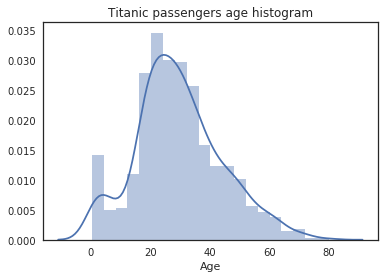

In [119]:
ax1 = sns.distplot(titanic['Age'].dropna())
ax1.set_title('Titanic passengers age histogram')

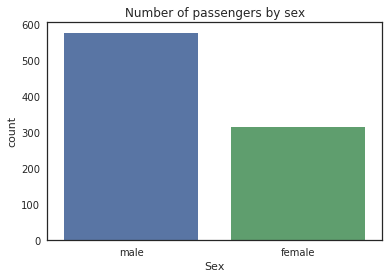

In [120]:
ax2 = sns.countplot(x = 'Sex', data=titanic)
ax2.set_title('Number of passengers by sex')

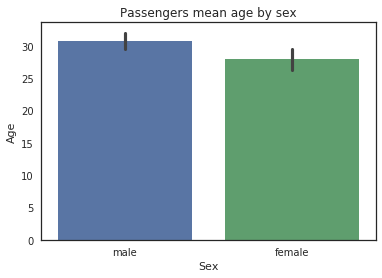

In [121]:
ax3 = sns.barplot(x="Sex", y="Age", data=titanic)
ax3.set_title('Passengers mean age by sex')

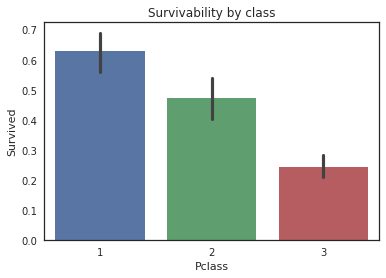

In [122]:
ax4 = sns.barplot(x ='Pclass', y='Survived', data=titanic)
ax4.set_title('Survivability by class')

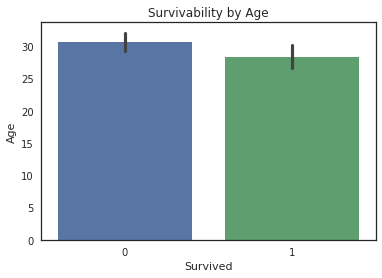

In [123]:
ax5 = sns.barplot(data=titanic, x='Survived', y='Age')
ax5.set_title('Survivability by Age')

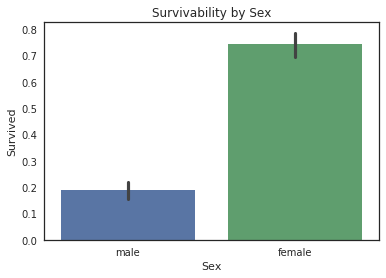

In [124]:
ax5 = sns.barplot(data=titanic, x='Sex', y='Survived')
ax5.set_title('Survivability by Sex')

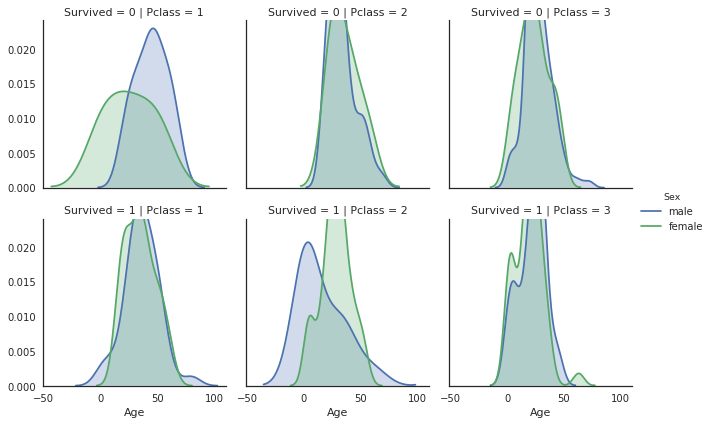

In [125]:
grid1 = sns.FacetGrid(data=titanic, col='Pclass', row='Survived', hue='Sex')
grid1.map(sns.kdeplot, 'Age', shade=True)
grid1.add_legend()

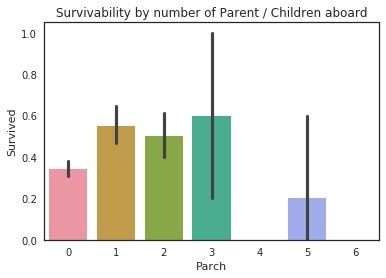

In [126]:
ax6 = sns.barplot(x='Parch', y='Survived', data=titanic)
ax6.set_title('Survivability by number of Parent / Children aboard')

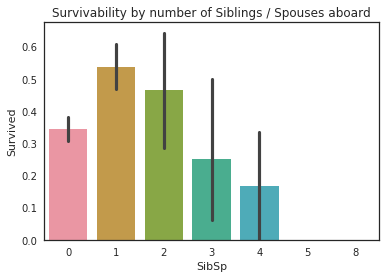

In [127]:
ax7 = sns.barplot(x='SibSp', y='Survived', data=titanic)
ax7.set_title('Survivability by number of Siblings / Spouses aboard')

### Comments

We can draw some interesting conclusions about these plots:

- Age distribution shows two major groups, one middle aged peaking about 25yo and a children group close to 2 or 3yo.

- There was more men than women aboard.

- The higher the passenger class is, the more likely to survive.

- Women are much more likely to survive than men.

- Among 2nd class people who survived there are two interesting age clusters: male babies and middle aged women.

- Among 1st class people who did not survive there are one interesting group of middle and over 50 aged men.

- Among all people who did not survive (first row of last plot) we can see groups of middle aged males peaking.

## Prediction models

### Simple model

#### Data Cleaning

In [128]:
# Data cleaning function (reusable in test df) for a simple model.

def clean(df):
    df_clean = df.copy()
    #Drop excluded columns
    columns_to_drop = ['PassengerId', 'Ticket', 'Name', 'Embarked', 'Cabin']
    df_clean.drop(columns_to_drop, axis=1, inplace=True)

    #Get dummy variables
    columns_to_dummies = ['Sex', 'Pclass']
    for col in columns_to_dummies:
        df_clean = dummify_df(df_clean, col)
        
    #Predicting missing values in Age column
    
    age_train = df_clean[df_clean['Age'].notnull()] 
    age_null = df_clean[df_clean['Age'].isnull()]
    
    age_pred_cols = list(age_train.columns)
    age_pred_cols.remove('Age')
    if 'Survived' in age_pred_cols:
        age_pred_cols.remove('Survived') #Prevent spillage
    age_target_col = 'Age'
    
    age_train.dropna(inplace=True)
    
    age_lm = LinearRegression()
    age_lm.fit(X=age_train[age_pred_cols].dropna(), y=age_train[age_target_col])
    
    predictions = age_lm.predict(age_null[age_pred_cols])
    df_clean.loc[df_clean['Age'].isnull(), 'Age'] = predictions
    df_clean.loc[df_clean['Age'] < 0, 'Age'] = 0
    
    #Handling missing values in the rest of the columns (filling with mean)
    
    for col in df_clean.columns:
        if (df_clean[col].dtype == 'float64' or df_clean[col].dtype == \
            'int64'or df_clean[col].dtype == 'uint8') and df_clean[col].isnull().any():
            df_clean[col].fillna(df_clean[col].mean(), inplace=True)
        
    
    return df_clean

In [129]:
# Clean data

test_clean = clean(test)
titanic_clean = clean(titanic)

# Common stuff to all algorithms
pred_cols = list(titanic_clean.columns)
pred_cols.remove('Survived')
target_cols = 'Survived'
kf = KFold(len(titanic_clean), shuffle=True, n_folds=10)

/home/david/anaconda3/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Testing popular classifiers

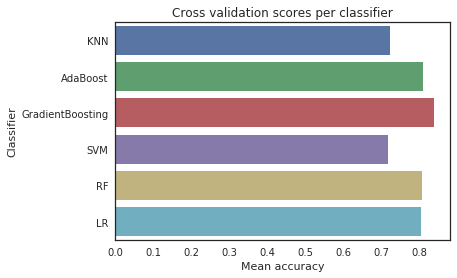

In [130]:
classifiers = {'KNN': KNeighborsClassifier(),
              'AdaBoost': AdaBoostClassifier(),
              'GradientBoosting': GradientBoostingClassifier(),
              'SVM': LinearSVC(),
              'RF': RandomForestClassifier(),
              'LR': LogisticRegression()}

classif_names = []
classif_score = []

for name, classifier in classifiers.items():
    classifier.random_state = 1
    classifier.fit(X=titanic_clean[pred_cols], y=titanic[target_cols])
    score = cross_val_score(classifier, titanic_clean[pred_cols], titanic_clean[target_cols], cv=kf, scoring='accuracy')
    classif_names.append(name)
    classif_score.append(score.mean())
    
ax_simple_model_classifiers = sns.barplot(y=classif_names, x=classif_score)
ax_simple_model_classifiers.set_title('Cross validation scores per classifier')
ax_simple_model_classifiers.set_xlabel('Mean accuracy')
ax_simple_model_classifiers.set_ylabel('Classifier')

#### Simple Model Analysis

As we can see after trying 6 of the most popular clasiffication algorithms, we can't go over 0.83 accuracy in our training set, which translates in about 0.75 in our testing set (Kaggle score). Even tuning some of these algorithms, it is going to be very hard going beyond that values without being more creative with the data we have. Let's using some techniques like outliers detection and feature engineering to see if we can make predictions more accurately.

### A more elaborated model

#### Data cleaning analysis

Previously we used a basic cleaning function which performs the following:

- Drop columns we considered as low valuable or difficult to process.
- Create dummy variables for categorical columns.
- Predicting missing values or filling with average.

If we want to succeed in this Kaggle competition, taking advantage of all data we can is a must, and also performing a more fine cleaning of our data, that is why we are going to introduce the following techniques into our cleaning pipeline:

- Outlier filtering (outliers affect very negatively prediction algorythms).
- Feature engineering (taking advantage of those dropped columns).
    - Creating a new family feature.
    - Creating a new family size feature.
    - Creating a new passenger deck feature.
    - Creating a new name length feature.
    - Creating a new title feature.
- Reducing skewness.
- Scaling features.

#### Outlier filtering

In order to filter outliers, we are going to calculate interquartile ranges for numerical variables. We will consider an outlier any value that is greater than the .75 quartile plus 1.5 times the interquartile range, or lower than the .25 quartile minus 1.5 times the iq range.

The next step is filtering (dropping) any value that is an outlier in more than 2 columns.

In [131]:
# Outlier filtering

def outlier_filter(df, cols):
    outliers_total = []
    for col in cols:
        q1 = df[col].quantile(.25)
        q3 = df[col].quantile(.75)
        iqr = q3 - q1
        iqr_filter = (df[col] <= q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr)
        outlier_indexes = df[iqr_filter].index
        outliers_total.extend(outlier_indexes)
    outliers_counter = Counter(outliers_total)
    outliers = [key for key, value in outliers_counter.items() if value > 2]
    return df.drop(outliers), df.loc[outliers,:]

In [132]:
titanic, outliers = outlier_filter(titanic, ['Age', 'SibSp', 'Parch', 'Fare'])

In [133]:
outliers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S


As we can see, outliers are people who paid a lot for the ticker, or people who belonged to big families (10 and 5 members). Is interesting to note that members with the same family (first word of the Name column) name and same values for SibSp and Parch would be part of the same family.

#### Feature Engineering

##### Detecting same family members (Family Features)

To detect the same family members we will iterate over the rows of the DataFrame. If someone has the same Family member (first word of the Name column), same number of parent / children (Parch) and Siblings / Spouses (SibSp) will be considered member of a family. We will give an ID to every family.

In [134]:
families = {}
def family_detector(row):
    family_code = row['Name'].split(',')[0] + str(row['SibSp']) + str(row['Parch'])
    return family_code
        

In [135]:
titanic['Family'] = titanic.apply(family_detector, axis=1)
print(Counter(titanic['Family']).most_common(5))

[('Andersson42', 6), ('Panula41', 5), ('Goodwin52', 5), ('Rice41', 4), ('Skoog32', 4)]


As we can see, this method make the trick and now we have a new categorical column with a code that identifies the family every passenger belong. Families should stick together during Titanic sinking, and probably all members of the same family shared the same fate. As usual, we have to create dummy variables in order to get advantage of this new feature.

##### Family size (Family Size Features)

May be interesting to see if the family size has an impact on survivability. Common sense tells us that single passengers and small families would have more chances of survivality.

In [136]:
titanic['Family_size'] = titanic["SibSp"] + titanic["Parch"]

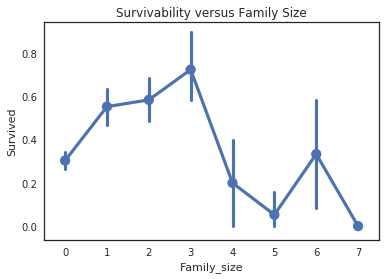

In [137]:
ax8 = sns.pointplot(x='Family_size', y='Survived', data=titanic)
ax8.set_title('Survivability versus Family Size')

In [138]:
def get_family_size(fsize):
    if fsize == 0:
        return 'single'
    elif fsize <= 2:
        return 'small'
    elif  2 < fsize < 5:
        return 'medium'
    elif fsize >= 5:
        return 'large'

titanic['Family_size'] = titanic['Family_size'].apply(get_family_size)

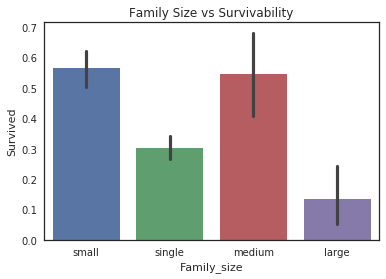

In [139]:
ax9 = sns.barplot(x='Family_size', y='Survived', data=titanic)
ax9.set_title('Family Size vs Survivability')

As the last graph states, medium size families and small have increased chances of survive against large families and single passengers.

##### Passenger deck (Deck Features)

We can investigate deeper cabin feature to see if there is some valuable information hidden there.

In [140]:
titanic['Cabin'] = titanic['Cabin'].str[0]
titanic.loc[titanic['Cabin'].isnull(),'Cabin'] = 'X' #Best practices

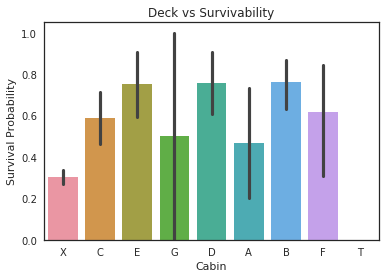

In [141]:
ax10 = sns.barplot(x='Cabin', y='Survived', data=titanic)
ax10.set_title('Deck vs Survivability')
ax10.set_ylabel('Survival Probability')

Passengers without a cabin ('X') value in Deck had lower chances of survive. G and A decks also seems to have a negative impact in survivability.

##### Ticket code (Ticket Features)

Let's investigate ticket code deeper:

In [142]:
titanic['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

As we can see. Some ticket codes are just numbers (ticket number) while others are a combination of strings and numbers (prefix + ticket number) separated by the ' ' character. Some of the prefixes have '.' and '/' characters. Let's make some cleaning of this column to take only prefixes and examine deeper what's going on with tickets.

In [143]:
titanic['Ticket'] = titanic['Ticket'].str.split(' ').str.get(0).str.replace('/','').str.replace('.', '')
only_numeric_tickets = titanic['Ticket'].str.isnumeric()
titanic.loc[only_numeric_tickets, 'Ticket'] = 'X'

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

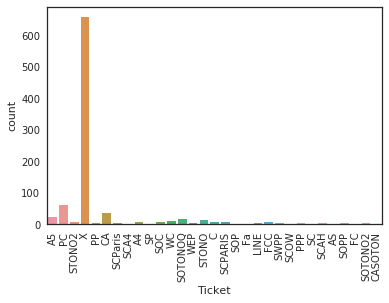

In [144]:
ax11 = sns.countplot(x='Ticket', data=titanic)
plt.xticks(rotation = 90)

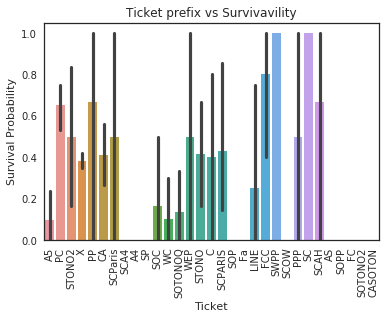

In [145]:
ax12 = sns.barplot(x='Ticket', y='Survived', data=titanic)
plt.xticks(rotation = 90)
        
ax12.set_title('Ticket prefix vs Survivavility')
ax12.set_ylabel('Survival Probability')

As we can see in the figure. Ticket can be somehow informative, but the relatively sparse sampling cause a high variability in survivality for people with the same ticket prefix. There are prefixes with as few as 1 sample. Let's get dummy variables as usual and visualize the first five rows.

##### Name (Family Size and Title Features)

Let's check if name adds some interesting info to our prediction problem. We have already used family names to create family features. But there are other interesting things to do with name:
- Name length: longer names and surnames are usually correlated with higher social positions in European countries.
- Name title: similarly to length, the name title can indicate some special position in society, or even age of the passenger. It can be interesting specially to passengers with missing age values.

Let's generate a new feature (Name_Length) and do some cleaning to extract the title.

In [146]:
titanic['Name_Length'] = titanic['Name'].str.len()
titanic['Title'] = titanic['Name'].str.split(',').str.get(1).str.split('.').str.get(0).str.strip(' ')

Let's check how name length impact survivability with a logistic regression plot which shows the relationship between the probability of survive versus name length (this is the recommended approach for binary variables like Survived versus continuous values like name length).

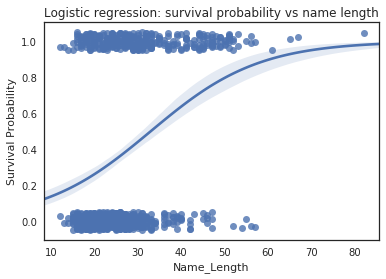

In [147]:
ax13 = sns.regplot(x='Name_Length', y='Survived', data=titanic, logistic=True, y_jitter=.05)
ax13.set_title('Logistic regression: survival probability vs name length')
ax13.set_ylabel('Survival Probability')

Figure shows that the longer the name is, the more chances of survive a passenger has. We can also expect this feature to be correlated with passenger class. Let's check it out.

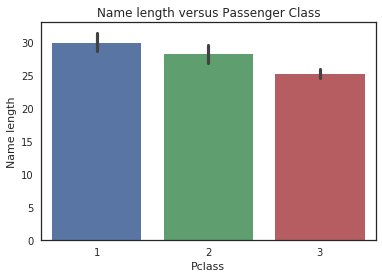

In [148]:
ax14 = sns.barplot(x='Pclass', y='Name_Length', data=titanic)
ax14.set_title('Name length versus Passenger Class')
ax14.set_ylabel('Name length')

In case of Title, a barplot will do the trick.

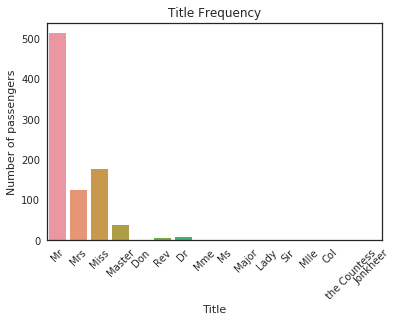

In [149]:
ax15 = sns.countplot(x='Title', data=titanic)
plt.xticks(rotation = 45)
ax15.set_title('Title Frequency')
ax15.set_ylabel('Number of passengers')

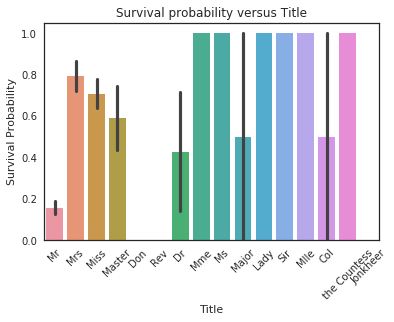

In [150]:
ax16 = sns.barplot(x='Title', y='Survived', data=titanic)
plt.xticks(rotation = 45)
ax16.set_title('Survival probability versus Title')
ax16.set_ylabel('Survival Probability')

Figure clearly shows that most of men (Mr.) did not survive the sinking, while most of women (Mrs. & Miss.) did. Young men (Master) also had an increased survivability over mature/old men. Doctors also had a higher survibability than common men. Rest of the titles are uncommon and hold only by a small number (less than 6) of people.

##### Embarked (Embarked Features)

Let's check if embarket column is good for improving our predictions.

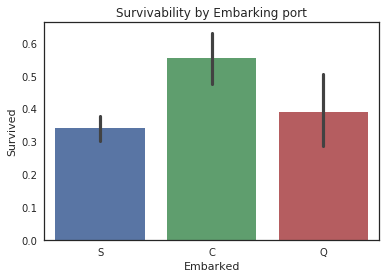

In [151]:
ax_emb_surv = sns.barplot(x='Embarked', y='Survived', data=titanic)
ax_emb_surv.set_title('Survivability by Embarking port')

As shown in the figure, passengers who embarked in Cherbourg were more likely to survive. But it really makes no sense. Probably, there is a difference in passenger sex or class by embarking port. Let's find those differences.

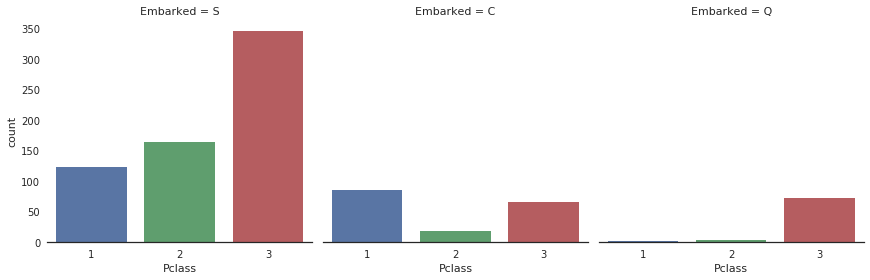

In [152]:
g_emb_class = sns.factorplot(x='Pclass', col='Embarked', data=titanic, kind='count').despine(left=True)

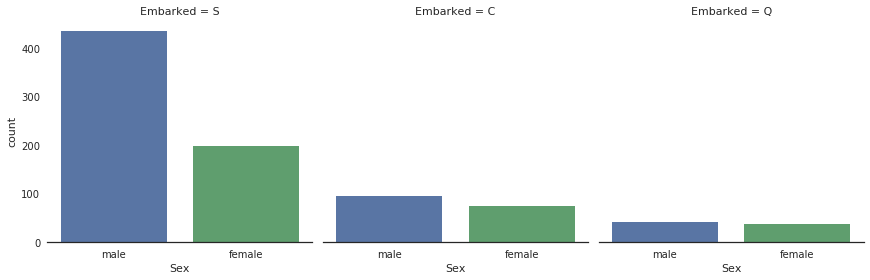

In [153]:
g_emb_sex = sns.factorplot(x='Sex', col='Embarked', data=titanic, kind='count').despine(left=True)

As we can see, passengers who embarked in Cherbourg were more likely to belong to first class or being female, which translates in higher survival chances. We can expect this column to be highly correlated with others and do not add much predicting power.

#### Skewness correction

Skewness variables is harmful to predictions algorithms and ML algorithms in general. In this section we are going to go over numeric variables, meassuring skewness and correcting if necessary using log() function.

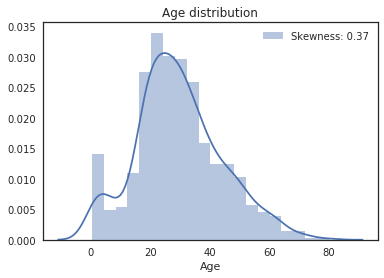

In [154]:
ax_age_dist = sns.distplot(titanic['Age'].dropna(), label="Skewness: %.2f"%(titanic['Age'].skew()))
ax_age_dist.set_title('Age distribution')
ax_age_dist.legend(loc='best')

Age distribution is shows a normal shape (although is bimodal) and does not require further transformations. Let's check other variables.

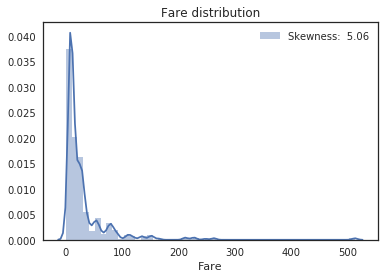

In [155]:
ax_fare_dist = sns.distplot(titanic['Fare'], label="Skewness: {:5.2f}".format(titanic['Fare'].skew()))
ax_fare_dist.set_title('Fare distribution')
ax_fare_dist.legend(loc='best')

Fare distribution is very skewed to the right (yeah, that is counterintuitive, but this is to the right, not the left). One common method to treat this skewness is using log() transformation in this variable.

In [156]:
titanic['Fare'] = titanic['Fare'].apply(lambda fare: np.log(fare) if fare > 0 else 0)

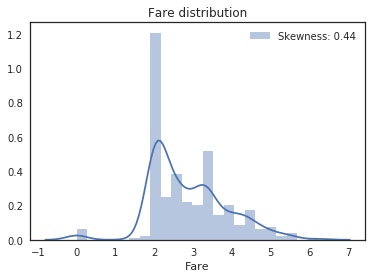

In [157]:
ax_fare_dist = sns.distplot(titanic['Fare'], label="Skewness: {:4.2f}".format(titanic['Fare'].skew()))
ax_fare_dist.set_title('Fare distribution')
ax_fare_dist.legend(loc='best')

Skewness is reduced from 5.06 to 0.44. For more information about skewness and kurtosis, check out [this][1] webpage. The rest of the features are categorical variables or integer-based ones.

[1]: https://tekmarathon.com/2015/11/13/importance-of-data-distribution-in-training-machine-learning-models/

In [ ]:
#### Scaling features


#### Scaling features

Some features are in a much larger scale than others. For example 'Fare' is in the order of hundreds of Pounds while age is in the order of decenes. This can affect our Machine Learning algorithm negatively. The best way to deal with that is scaling our features: make a transformation so the maximum value is +1 and the minimum possible -1. To accomplish that we can use sklearn preprocessing tool MinMaxScaler.

In [160]:
scaler = MinMaxScaler()

titanic[['Age', 'Fare']] = scaler.fit_transform(titanic[['Age', 'Fare']])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [169]:
filter = pd.isnull(titanic['Age'])

In [172]:
pd.isnan(titanic)

AttributeError: module 'pandas' has no attribute 'isnan'